In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import LombScargle

plt.style.use('seaborn-whitegrid')

## Kepler

In [2]:
from astropy.io import fits
from astropy.table import Table

hdulist = fits.open('kplr007198959-2009259160929_llc.fits')
data = Table(hdulist[1].data)
df = data.to_pandas()[['TIME', 'SAP_FLUX', 'SAP_FLUX_ERR']]
df = df.dropna()

In [3]:
def compute_models(N):
    for nterms in range(1, N + 1):
        ls = LombScargle(df['TIME'], df['SAP_FLUX'], df['SAP_FLUX_ERR'], nterms=nterms)
        freq, power = ls.autopower(minimum_frequency=0,
                                   maximum_frequency=8)
        yield ls, freq, power
        
results = list(compute_models(3))

_, freq, power = results[0]
best_freq = freq[np.argmax(power)]

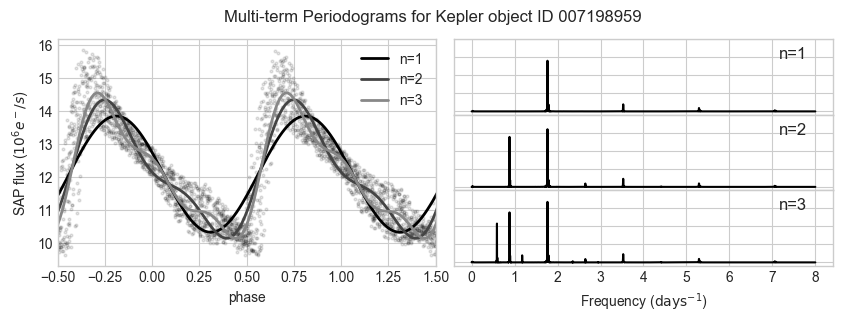

In [4]:
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(3, 2, wspace=0.05, hspace=0)

ax = fig.add_subplot(gs[:, 0])
phase = (df['TIME'] * best_freq) % 1 - np.random.randint(-1, 2, df.shape[0])
flux = df['SAP_FLUX'] / 1E6

ax.plot(phase, flux.values, 'ok', alpha=0.1, markersize=2, rasterized=True)

phase_fit = np.linspace(-1, 2, 200)
colors=['black', '#444444', '#888888']
for model, color in zip(results, colors):
    model = model[0]
    y_fit = model.model(phase_fit / best_freq, best_freq) / 1E6
    ax.plot(phase_fit, y_fit, '-', lw=2, color=color,
            label='n={0}'.format(model.nterms))
ax.set(xlim=(-0.5, 1.5),
       xlabel='phase', ylabel='SAP flux ($10^6 e^-/s$)')
ax.legend(title=None)

ax = [fig.add_subplot(gs[i, 1]) for i in range(3)]

for axi, model in zip(ax, results):
    ls, freq, power = model
    axi.plot(freq, power, '-k', rasterized=True)
    axi.set(ylim=(-0.05, 1))
    axi.yaxis.set_major_locator(plt.MultipleLocator(0.25))
    axi.yaxis.set_major_formatter(plt.NullFormatter())
    axi.text(7.8, 0.9, 'n={0}'.format(ls.nterms),
             ha='right', va='top', size=12)
    
for axi in ax[:-1]:
    axi.xaxis.set_major_formatter(plt.NullFormatter())
ax[-1].set_xlabel(r'Frequency (${\rm days}^{-1}$)')
    
fig.suptitle('Multi-term Periodograms for Kepler object ID 007198959', size=12)

fig.savefig('fig21_kepler_multiterm.pdf')

## LINEAR

In [5]:
import pandas as pd
data = pd.read_csv('LINEAR_11375941.csv')
data.head()

,t,mag,magerr
0,52650.434545,15.969,0.035
1,52650.448450,16.036,0.039
2,52650.462420,15.990,0.035
3,52650.476485,16.027,0.035
4,52650.490443,15.675,0.030


In [6]:
def compute_models(N):
    for nterms in range(1, N + 1):
        ls = LombScargle(data['t'].values, data['mag'].values, data['magerr'].values, nterms=nterms)
        freq, power = ls.autopower(minimum_frequency=24. / 12,
                                   maximum_frequency=24. / 1)
        yield ls, freq, power
        
results = list(compute_models(3))

_, freq, power = results[0]
best_freq = freq[np.argmax(power)]

In [7]:
24. / best_freq

2.5801481945224123

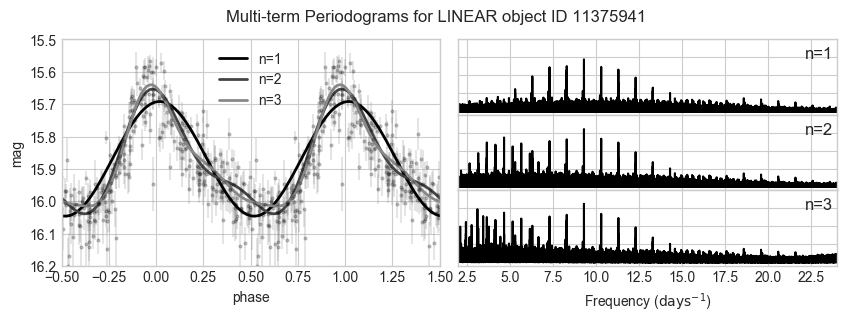

In [8]:
fig = plt.figure(figsize=(10, 3))
gs = plt.GridSpec(3, 2, wspace=0.05, hspace=0)

ax = fig.add_subplot(gs[:, 0])
phase = (data['t'].values * best_freq) % 1
mag = data['mag'].values
magerr = data['magerr'].values

for offset in [-1, 0, 1]:
    ax.errorbar(phase + offset, mag, magerr, fmt='ok', ecolor='gray', capsize=0,
                alpha=0.2, markersize=2, rasterized=True)

phase_fit = np.linspace(-1, 2, 200)
colors=['black', '#444444', '#888888']
for model, color in zip(results, colors):
    model = model[0]
    y_fit = model.model(phase_fit / best_freq, best_freq)
    ax.plot(phase_fit, y_fit, '-', lw=2, color=color,
            label='n={0}'.format(model.nterms))
ax.set(xlim=(-0.5, 1.5), ylim=(16.2, 15.5),
       xlabel='phase', ylabel='mag')
ax.legend(title=None, loc='upper center')

ax = [fig.add_subplot(gs[i, 1]) for i in range(3)]

for axi, model in zip(ax, results):
    ls, freq, power = model
    axi.plot(freq, power, '-k', rasterized=True)
    axi.set(xlim=(2, 24), ylim=(-0.05, 1))
    axi.yaxis.set_major_locator(plt.MultipleLocator(0.25))
    axi.yaxis.set_major_formatter(plt.NullFormatter())
    axi.text(23.8, 0.9, 'n={0}'.format(ls.nterms),
             ha='right', va='top', size=12)
    
for axi in ax[:-1]:
    axi.xaxis.set_major_formatter(plt.NullFormatter())
ax[-1].set_xlabel(r'Frequency (${\rm days}^{-1}$)')
    
fig.suptitle('Multi-term Periodograms for LINEAR object ID 11375941', size=12)

fig.savefig('fig22_LINEAR_multiterm.pdf')